In [107]:
import sys
sys.path.append('..')
import src.HamiltonianTerms as ham
from src.MatrixToQISKITCircuit import *
from src.BinaryEncodings import *
import numpy as np
import sympy as sp
import math



dim = 16
nqubits=4
hmat = ham.number_op(dim) + 0.5*np.identity(dim)

mtoqc = MatrixToPauliString(np.asarray(hmat))
mtoqc.convert(standard_encode)

In [108]:
print(sp.expand(mtoqc.sum_of_paulis))

8.0*I^0*I^1*I^2*I^3 - 4.0*I^0*I^1*I^2*Z^3 - 2.0*I^0*I^1*I^3*Z^2 - 1.0*I^0*I^2*I^3*Z^1 - 0.5*I^1*I^2*I^3*Z^0


In [109]:
print(mtoqc.pauli_strings_as_list())

defaultdict(<class 'complex'>, {'IIII': (8+0j), 'ZIII': (-0.5+0j), 'IZII': (-1+0j), 'IIZI': (-2+0j), 'IIIZ': (-4+0j)})


In [110]:
from qiskit.aqua.operators import I,X,Y,Z,Zero,PauliTrotterEvolution
from qiskit.circuit import Parameter

char_to_op={'I': I, 'X': X, 'Y': Y, 'Z': Z}

In [112]:
expr = 0
for pstring, coef in mtoqc.pauli_strings_as_list().items():
    term = char_to_op[pstring[0]]
    for char in pstring[1:]:
        term = term^char_to_op[char]
    expr += coef.real*term

In [113]:
evo_time = Parameter('t')
evolution_op = (evo_time*expr).exp_i()
print(evolution_op)

e^(-i*1.0*t * SummedOp([
  24.0 * IIII,
  -1.5 * ZIII,
  -3.0 * IZII,
  -6.0 * IIZI,
  -12.0 * IIIZ
]))


In [114]:
print(evolution_op @ Zero)

ComposedOp([
  e^(-i*1.0*t * SummedOp([
    24.0 * IIII,
    -1.5 * ZIII,
    -3.0 * IZII,
    -6.0 * IIZI,
    -12.0 * IIIZ
  ])),
  DictStateFn({'0000': 1})
])


In [115]:
fixed_time = evolution_op.bind_parameters({evo_time: 1})

In [116]:
print(fixed_time @ Zero)

ComposedOp([
  e^(-i*SummedOp([
    24.0 * IIII,
    -1.5 * ZIII,
    -3.0 * IZII,
    -6.0 * IIZI,
    -12.0 * IIIZ
  ])),
  DictStateFn({'0000': 1})
])


In [117]:
trotterized = PauliTrotterEvolution(trotter_mode='suzuki').convert(fixed_time)

In [118]:
from qiskit import QuantumCircuit, transpile

In [119]:
qc = QuantumCircuit(nqubits, nqubits)

In [121]:
qc.append(trotterized, [i for i in range(nqubits)])

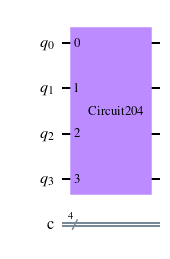

In [122]:
qc.draw('mpl')

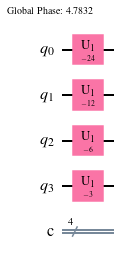

In [123]:
transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z']).draw('mpl')

In [95]:
from qiskit import (
    execute,
    Aer)
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ
from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()

/home/chrisculver/miniconda3/envs/QuantumComputing/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [96]:
noise_backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(noise_backend)

In [99]:
simulator = Aer.get_backend('qasm_simulator')

qc.measure([0,1,2],[0,1,2])

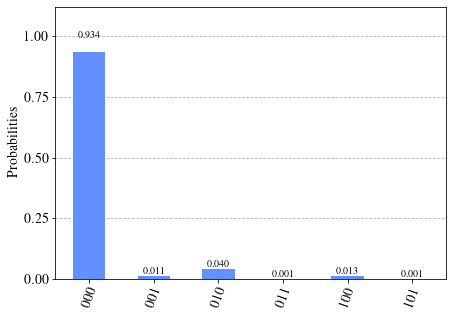

In [102]:
job = execute(qc, simulator, shots=1000, noise_model=noise_model)
result=job.result()
counts = result.get_counts(qc)
plot_histogram(counts)